<a href="https://colab.research.google.com/github/190-785/AI-ML-Project-Grafest/blob/main/Kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from glob import glob
from sklearn.model_selection import train_test_split

ZIP_FILE_PATH = '/content/kidney+stone.zip'
EXTRACT_DIR = 'extracted_kidney_stone'
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 30

if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)

with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

test_dir = os.path.join(EXTRACT_DIR, 'test')
train_dir = os.path.join(EXTRACT_DIR, 'train')
valid_dir = os.path.join(EXTRACT_DIR, 'valid')

print(f"Test directory: {test_dir}")
print(f"Train directory: {train_dir}")
print(f"Valid directory: {valid_dir}")

final_test_dir = os.path.join(test_dir, 'final')
if os.path.exists(final_test_dir):
    for filename in os.listdir(final_test_dir):
        if filename.endswith((".jpg", ".png")):
            print(f"Image found: {os.path.join(final_test_dir, filename)}")
else:
    print(f"'final' folder not found in {test_dir}")

def load_data(image_dir, label_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    label_paths = sorted(glob(os.path.join(label_dir, "*.txt")))
    return image_paths, label_paths

train_images, train_labels = load_data("dataset/train/images", "dataset/train/labels")
val_images, val_labels = load_data("dataset/val/images", "dataset/val/labels")
test_images, test_labels = load_data("dataset/test/images", "dataset/test/labels")

def parse_sample(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.io.read_file(label_path)
    label = tf.strings.strip(label)
    label = tf.strings.split(label)
    bbox = tf.strings.to_number(label, out_type=tf.float32)

    return image, bbox

def tf_wrapper(image_path, label_path):
    return tf.py_function(parse_sample, [image_path, label_path], [tf.float32, tf.float32])
def build_dataset(image_paths, label_paths):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_images, train_labels)
val_ds = build_dataset(val_images, val_labels)
test_ds = build_dataset(test_images, test_labels)


Test directory: extracted_kidney_stone/test
Train directory: extracted_kidney_stone/train
Valid directory: extracted_kidney_stone/valid
'final' folder not found in extracted_kidney_stone/test


In [ ]:
import os
import zipfile
import glob
import numpy as np
import tensorflow as tf
import cv2

ZIP_FILE_PATH = '/content/kidney+stone.zip'
EXTRACT_DIR = '/content/extracted_kidney_stone'
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 30
LR = 1e-4
GRID_SIZE = IMAGE_SIZE // 32
IOU_THRESHOLD = 0.5

if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)

train_img_paths = sorted(glob.glob(os.path.join(EXTRACT_DIR, 'train', 'images', '*.jpg')))
train_lbl_paths = sorted(glob.glob(os.path.join(EXTRACT_DIR, 'train', 'labels', '*.txt')))
val_img_paths   = sorted(glob.glob(os.path.join(EXTRACT_DIR, 'valid', 'images', '*.jpg')))
val_lbl_paths   = sorted(glob.glob(os.path.join(EXTRACT_DIR, 'valid', 'labels', '*.txt')))

class KidneyStoneSequence(tf.keras.utils.Sequence):
    def __init__(self, img_paths, lbl_paths, batch_size, image_size):
        self.img_paths = img_paths
        self.lbl_paths = lbl_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.grid_size = image_size // 32
    def __len__(self):
        return len(self.img_paths) // self.batch_size
    def __getitem__(self, idx):
        batch_imgs = self.img_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_lbls = self.lbl_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        X = np.zeros((self.batch_size, self.image_size, self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, self.grid_size, self.grid_size, 5), dtype=np.float32)
        for k, (img_p, lbl_p) in enumerate(zip(batch_imgs, batch_lbls)):
            img = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)
            img = cv2.resize(img, (self.image_size, self.image_size)).astype(np.float32) / 255.0
            X[k, ..., 0] = img
            parts = open(lbl_p).read().split()
            x_c, y_c, w, h = map(float, parts[1:5])
            cell_w = self.image_size / self.grid_size
            cell_h = self.image_size / self.grid_size
            xc = x_c * self.image_size
            yc = y_c * self.image_size
            j = int(xc // cell_w)
            i_cell = int(yc // cell_h)
            tx = (xc - j * cell_w) / cell_w
            ty = (yc - i_cell * cell_h) / cell_h
            y[k, i_cell, j, :] = [tx, ty, w, h, 1.0]
        return X, y

train_seq = KidneyStoneSequence(train_img_paths, train_lbl_paths, BATCH_SIZE, IMAGE_SIZE)
val_seq   = KidneyStoneSequence(val_img_paths,   val_lbl_paths,   BATCH_SIZE, IMAGE_SIZE)

def build_detector():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    x = inputs
    for filters in [16, 32, 64, 128, 256]:
        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPool2D(2)(x)
    x = tf.keras.layers.Conv2D(5, 1, padding='same')(x)
    return tf.keras.Model(inputs, x, name="KidneyStoneDetector")

model = build_detector()

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
smooth_l1 = tf.keras.losses.Huber()

def detection_loss(y_true, y_pred):
    t_xywh = y_true[..., 0:4]
    t_obj  = y_true[..., 4:5]
    p_xywh = y_pred[..., 0:4]
    p_obj  = y_pred[..., 4:5]
    loss_obj = bce(t_obj, p_obj)
    mask = tf.cast(tf.equal(t_obj, 1.0), tf.float32)
    loc_loss = smooth_l1(t_xywh * mask, p_xywh * mask)
    return loss_obj + loc_loss

def obj_acc(y_true, y_pred):
    t_obj = y_true[..., 4:5]
    p_obj = tf.sigmoid(y_pred[..., 4:5])
    return tf.keras.metrics.binary_accuracy(t_obj, p_obj)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss=detection_loss,
    metrics=[obj_acc]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=NUM_EPOCHS,
    callbacks=callbacks
)

def infer(img_tensor, conf_thresh=0.5):
    pred = model(img_tensor)[0].numpy()
    boxes, scores = [], []
    grid_h = IMAGE_SIZE / GRID_SIZE
    grid_w = IMAGE_SIZE / GRID_SIZE
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            tx, ty, tw, th, c = pred[i, j]
            score = tf.sigmoid(c).numpy()
            if score < conf_thresh:
                continue
            xc = (j + tf.sigmoid(tx).numpy()) * grid_w
            yc = (i + tf.sigmoid(ty).numpy()) * grid_h
            w_box = tw * IMAGE_SIZE
            h_box = th * IMAGE_SIZE
            x1 = xc - w_box / 2
            y1 = yc - h_box / 2
            x2 = xc + w_box / 2
            y2 = yc + h_box / 2
            boxes.append([x1, y1, x2, y2])
            scores.append(score)
    if not boxes:
        return [], []
    boxes = tf.constant(boxes, dtype=tf.float32)
    scores = tf.constant(scores)
    idx = tf.image.non_max_suppression(boxes, scores, max_output_size=10, iou_threshold=IOU_THRESHOLD)
    selected = tf.gather(boxes, idx).numpy()
    sel_scores = tf.gather(scores, idx).numpy()
    return selected, sel_scores


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [ ]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

class MySequence(Sequence):
    def __init__(self, X, y, batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.X) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        batch_X = self.X[start:end]
        batch_y = self.y[start:end]
        return np.array(batch_X), np.array(batch_y)


In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from glob import glob
from sklearn.model_selection import train_test_split

# Constants
ZIP_FILE_PATH = '/content/kidney+stone.zip'
EXTRACT_DIR = 'extracted_kidney_stone'
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 30

# Extract data if not already extracted
if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

# Define directories
train_dir = os.path.join(EXTRACT_DIR, 'train')
valid_dir = os.path.join(EXTRACT_DIR, 'valid')
test_dir = os.path.join(EXTRACT_DIR, 'test')

# Debug print
print(f"Train directory: {train_dir}")
print(f"Validation directory: {valid_dir}")
print(f"Test directory: {test_dir}")

# Load image and label paths
def load_data(image_dir, label_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    label_paths = sorted(glob(os.path.join(label_dir, "*.txt")))
    return image_paths, label_paths

train_images, train_labels = load_data(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'labels'))
val_images, val_labels = load_data(os.path.join(valid_dir, 'images'), os.path.join(valid_dir, 'labels'))
test_images, test_labels = load_data(os.path.join(test_dir, 'images'), os.path.join(test_dir, 'labels'))

# Check if data is loaded
print(f"# Train samples: {len(train_images)}")
print(f"# Validation samples: {len(val_images)}")
print(f"# Test samples: {len(test_images)}")

# Parse individual image-label pair
def parse_sample(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.io.read_file(label_path)
    label = tf.strings.strip(label)
    label = tf.strings.split(label)
    bbox = tf.strings.to_number(label, out_type=tf.float32)  # [x, y, w, h]
    return image, bbox

# Wrap in tf.py_function
def tf_wrapper(image_path, label_path):
    image, bbox = tf.py_function(parse_sample, [image_path, label_path], [tf.float32, tf.float32])
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    bbox.set_shape([4])
    return image, bbox

# Build dataset
def build_dataset(image_paths, label_paths):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_images, train_labels)
val_ds = build_dataset(val_images, val_labels)
test_ds = build_dataset(test_images, test_labels)

# Define model
def build_model():
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='sigmoid')  # bounding box output
    ])
    return model

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS
)

# Evaluate
test_loss, test_mae = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Optional: Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


Train directory: extracted_kidney_stone/train
Validation directory: extracted_kidney_stone/valid
Test directory: extracted_kidney_stone/test
# Train samples: 0
# Validation samples: 0
# Test samples: 0
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30


ValueError: math domain error

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import math # Import math library

from glob import glob
from sklearn.model_selection import train_test_split

# Constants
ZIP_FILE_PATH = '/content/kidney+stone.zip'
BASE_EXTRACT_DIR = 'extracted_data' # Changed base name slightly for clarity
EXPECTED_DATA_FOLDER = 'kidney+stone' # Or whatever the top folder *inside* the zip is called

# --- Extraction ---
if not os.path.exists(BASE_EXTRACT_DIR):
    print(f"Creating directory: {BASE_EXTRACT_DIR}")
    os.makedirs(BASE_EXTRACT_DIR)
    print(f"Extracting {ZIP_FILE_PATH} to {BASE_EXTRACT_DIR}")
    try:
        with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
            zip_ref.extractall(BASE_EXTRACT_DIR)
        print("Extraction complete.")
    except zipfile.BadZipFile:
        print(f"Error: {ZIP_FILE_PATH} is not a valid zip file or is corrupted.")
        exit() # Stop execution if zip is bad
    except FileNotFoundError:
        print(f"Error: Zip file not found at {ZIP_FILE_PATH}")
        exit() # Stop execution if zip not found

# --- Define Corrected Data Directories ---
# Check if the zip extracted into an extra subfolder
actual_data_root = os.path.join(BASE_EXTRACT_DIR, EXPECTED_DATA_FOLDER)
if not os.path.isdir(actual_data_root):
    # If the expected subfolder isn't there, maybe extraction was direct
    actual_data_root = BASE_EXTRACT_DIR
    print(f"Note: Data seems to be directly in {BASE_EXTRACT_DIR}, not in a '{EXPECTED_DATA_FOLDER}' subfolder.")
else:
    print(f"Data root identified as: {actual_data_root}")


train_dir = os.path.join(actual_data_root, 'train')
valid_dir = os.path.join(actual_data_root, 'valid')
test_dir = os.path.join(actual_data_root, 'test')

# Debug print
print(f"Checking for Train directory: {train_dir}")
print(f"Checking for Validation directory: {valid_dir}")
print(f"Checking for Test directory: {test_dir}")

# --- Load image and label paths ---
def load_data(data_subdir):
    image_dir = os.path.join(data_subdir, 'images')
    label_dir = os.path.join(data_subdir, 'labels')
    print(f"Searching for images in: {image_dir}")
    print(f"Searching for labels in: {label_dir}")

    # Check if directories exist
    if not os.path.isdir(image_dir):
        print(f"Warning: Image directory not found: {image_dir}")
        return [], []
    if not os.path.isdir(label_dir):
        print(f"Warning: Label directory not found: {label_dir}")
        return [], []

    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg"))) # Use *.jpg, adjust if needed (e.g., *.png)
    label_paths = sorted(glob(os.path.join(label_dir, "*.txt")))

    # Simple check for matching counts (doesn't guarantee pairing)
    if len(image_paths) != len(label_paths):
       print(f"Warning: Mismatch in count for {data_subdir}. Images: {len(image_paths)}, Labels: {len(label_paths)}")
       # Decide how to handle mismatch - here we'll proceed but it might cause issues later
       # A more robust approach would pair based on filenames

    return image_paths, label_paths

train_images, train_labels = load_data(train_dir)
val_images, val_labels = load_data(valid_dir)
test_images, test_labels = load_data(test_dir)

# Check if data is loaded
print(f"# Train samples found: {len(train_images)}")
print(f"# Validation samples found: {len(val_images)}")
print(f"# Test samples found: {len(test_images)}")

# --- Add a check before proceeding ---
if len(train_images) == 0 or len(val_images) == 0:
    print("\nError: No training or validation samples were found.")
    print("Please check the directory structure and paths after extraction:")
    print(f"  - Expected train images in: {os.path.join(train_dir, 'images')}")
    print(f"  - Expected train labels in: {os.path.join(train_dir, 'labels')}")
    print(f"  - Expected validation images in: {os.path.join(valid_dir, 'images')}")
    print(f"  - Expected validation labels in: {os.path.join(valid_dir, 'labels')}")
    exit() # Stop execution if no data

# --- Constants ---
IMAGE_SIZE = 224
BATCH_SIZE = 16 # Make sure batch size is not larger than smallest dataset split
NUM_EPOCHS = 30

# --- Parsing and Dataset Building (Your functions seem okay, but depend on correct input) ---
def parse_sample(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    label_content = tf.io.read_file(label_path)
    # Assuming YOLO format: class_id x_center y_center width height (normalized)
    parts = tf.strings.split(label_content, sep=' ')
    # Extract bounding box coordinates (x, y, w, h) - skip class_id
    # IMPORTANT: Ensure your label format IS [class_id x y w h] and they are numbers!
    bbox = tf.strings.to_number(parts[1:], out_type=tf.float32)
    # If your format is just [x y w h], use:
    # bbox = tf.strings.to_number(parts, out_type=tf.float32)
    return image, bbox

# Wrap in tf.py_function
def tf_wrapper(image_path, label_path):
    # Define the output types and shapes
    image, bbox = tf.py_function(
        parse_sample,
        [image_path, label_path],
        [tf.float32, tf.float32]
    )
    # Set shapes explicitly for TensorFlow graph mode
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    bbox.set_shape([4]) # Assuming 4 values for bbox [x, y, w, h]
    return image, bbox

# Build dataset
def build_dataset(image_paths, label_paths, batch_size):
    if not image_paths or not label_paths: # Handle empty input lists
        return None
    ds = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle needs buffer_size > 0
    buffer_size = len(image_paths)
    if buffer_size > 0:
       ds = ds.shuffle(buffer_size=min(buffer_size, 512)) # Shuffle buffer shouldn't exceed dataset size
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_images, train_labels, BATCH_SIZE)
val_ds = build_dataset(val_images, val_labels, BATCH_SIZE)
test_ds = build_dataset(test_images, test_labels, BATCH_SIZE)


# Check if datasets were created
if train_ds is None or val_ds is None:
    print("Error: Could not create training or validation datasets (likely due to missing files).")
    exit()

# --- Define model ---
def build_model():
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet')
    base_model.trainable = False # Freeze base model layers

    model = tf.keras.Sequential([
        # No separate InputLayer needed if base_model defines input_shape
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2), # Added dropout for regularization
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='sigmoid') # Outputting 4 values (bbox), sigmoid ensures range [0, 1] if normalized
    ])
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Use Adam optimizer object
              loss='mse', # Mean Squared Error is common for regression (bbox)
              metrics=['mae']) # Mean Absolute Error

print(model.summary()) # Print model summary

print("\nStarting model training...")
# --- Train model ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    # Add callbacks for better training (optional but recommended)
    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

print("\nTraining finished.")

# --- Evaluate ---
if test_ds: # Only evaluate if test data exists
    print("\nEvaluating on test data...")
    test_loss, test_mae = model.evaluate(test_ds)
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("\nNo test data found to evaluate.")


# --- Optional: Plot training history ---
print("\nPlotting training history...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.tight_layout()
plt.show()
print("Script finished.")

Note: Data seems to be directly in extracted_data, not in a 'kidney+stone' subfolder.
Checking for Train directory: extracted_data/train
Checking for Validation directory: extracted_data/valid
Checking for Test directory: extracted_data/test
Searching for images in: extracted_data/train/images
Searching for labels in: extracted_data/train/labels
Searching for images in: extracted_data/valid/images
Searching for labels in: extracted_data/valid/labels
Searching for images in: extracted_data/test/images
Searching for labels in: extracted_data/test/labels
# Train samples found: 0
# Validation samples found: 0
# Test samples found: 0

Error: No training or validation samples were found.
Please check the directory structure and paths after extraction:
  - Expected train images in: extracted_data/train/images
  - Expected train labels in: extracted_data/train/labels
  - Expected validation images in: extracted_data/valid/images
  - Expected validation labels in: extracted_data/valid/labels
Er

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None

Starting model training...


AttributeError: 'NoneType' object has no attribute 'shape'

In [56]:
import os
import zipfile
from glob import glob

import tensorflow as tf
import matplotlib.pyplot as plt

# --- Constants ---
ZIP_FILE_PATH        = '/content/kidney+stone.zip'
BASE_EXTRACT_DIR     = 'extracted_data'
EXPECTED_DATA_FOLDER = 'kidney stone'
IMAGE_SIZE           = 224
BATCH_SIZE           = 16
NUM_EPOCHS           = 10             # adjust as needed
MODEL_PATH           = 'kidney_stone_mobilenetv2_model.h5'
# Threshold for bbox coordinate closeness (normalized units)
CLOSENESS_THRESHOLD  = 0.05

# --- Unzip dataset ---
if not os.path.exists(BASE_EXTRACT_DIR):
    os.makedirs(BASE_EXTRACT_DIR)
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as z:
        z.extractall(BASE_EXTRACT_DIR)

# --- Locate data root ---
actual_data_root = os.path.join(BASE_EXTRACT_DIR, EXPECTED_DATA_FOLDER)
if not os.path.isdir(actual_data_root):
    actual_data_root = BASE_EXTRACT_DIR

train_dir = os.path.join(actual_data_root, 'train')
valid_dir = os.path.join(actual_data_root, 'valid')
test_dir  = os.path.join(actual_data_root, 'test')

# --- Load file paths ---
def load_data(split_dir):
    imgs = sorted(glob(os.path.join(split_dir, 'final', '*.jpg')))
    lbls = sorted(glob(os.path.join(split_dir, 'labels', '*.txt')))
    if len(imgs) != len(lbls):
        raise ValueError(f"Mismatched images ({len(imgs)}) vs labels ({len(lbls)}) in {split_dir}")
    return imgs, lbls

train_images, train_labels = load_data(train_dir)
val_images,   val_labels   = load_data(valid_dir)
test_images,  test_labels  = load_data(test_dir)

print(f"Train: {len(train_images)}  Val: {len(val_images)}  Test: {len(test_images)}")

# --- Pure-TF parse (no augmentation) ---
def parse_sample(image_path, label_path):
    # Image load + resize
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    # Label (YOLO: class x_center y_center width height)
    lbl = tf.io.read_file(label_path)
    parts = tf.strings.split(lbl)
    parts_num = tf.strings.to_number(parts, out_type=tf.float32)
    # ensure at least 5 tokens
    parts_num = tf.pad(parts_num, [[0, 5 - tf.shape(parts_num)[0]]])
    coords = parts_num[1:5]  # x_center, y_center, w, h
    coords = tf.ensure_shape(coords, [4])

    return img, coords

# --- Augmentation fn (train only) ---
def augment_fn(img, coords):
    # random horizontal flip
    do_h = tf.less(tf.random.uniform([], 0, 1.0), 0.5)
    img = tf.cond(do_h, lambda: tf.image.flip_left_right(img), lambda: img)
    coords = tf.cond(do_h, lambda: tf.stack([1 - coords[0], coords[1], coords[2], coords[3]]), lambda: coords)

    # random vertical flip
    do_v = tf.less(tf.random.uniform([], 0, 1.0), 0.5)
    img = tf.cond(do_v, lambda: tf.image.flip_up_down(img), lambda: img)
    coords = tf.cond(do_v, lambda: tf.stack([coords[0], 1 - coords[1], coords[2], coords[3]]), lambda: coords)

    # brightness & contrast
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.7, 1.3)

    return img, coords

# --- Build tf.data.Dataset ---
def build_dataset(img_paths, lbl_paths, batch_size, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, lbl_paths))
    ds = ds.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(buffer_size=len(img_paths))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_images, train_labels, BATCH_SIZE, augment=True)
val_ds   = build_dataset(val_images,   val_labels,   BATCH_SIZE)
test_ds  = build_dataset(test_images,  test_labels,  BATCH_SIZE)

# --- Bounding Box Accuracy Metric ---
def bbox_accuracy(y_true, y_pred):
    # True if all coords within threshold
    diff = tf.abs(y_true - y_pred)
    within = tf.reduce_all(diff <= CLOSENESS_THRESHOLD, axis=-1)
    return tf.reduce_mean(tf.cast(within, tf.float32))

# --- Model Definition ---
def build_model():
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = False

    return tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='sigmoid'),
    ])

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(),
    metrics=['mae', bbox_accuracy]
)
model.summary()

# --- Training ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
)

# --- Save model ---
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# --- Plot training curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Huber Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['bbox_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.plot(history.history['val_bbox_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Metric'); plt.legend()

plt.tight_layout()
plt.show()


Train: 1054  Val: 123  Test: 123


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node Pad defined at (most recent call last):
<stack traces unavailable>
Error in user-defined function passed to ParallelMapDatasetV2:22216 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2::ParallelMapV2: Paddings must be non-negative: 0 -5
	 [[{{node Pad}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_6849986]

In [57]:
import os
import zipfile
from glob import glob

import numpy as np
import tensorflow as tf

# --- Constants ---
ZIP_FILE_PATH        = '/content/kidney+stone.zip'
BASE_EXTRACT_DIR     = 'extracted_data'
EXPECTED_DATA_FOLDER = 'kidney stone'
IMAGE_SIZE           = 224
BATCH_SIZE           = 16
MODEL_PATH           = 'kidney_stone_mobilenetv2_model.h5'

# --- Unzip dataset if needed ---
if not os.path.exists(BASE_EXTRACT_DIR):
    os.makedirs(BASE_EXTRACT_DIR)
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as z:
        z.extractall(BASE_EXTRACT_DIR)

# --- Locate data root ---
actual_data_root = os.path.join(BASE_EXTRACT_DIR, EXPECTED_DATA_FOLDER)
if not os.path.isdir(actual_data_root):
    actual_data_root = BASE_EXTRACT_DIR

test_dir  = os.path.join(actual_data_root, 'test')

# --- Load file paths ---
def load_data(split_dir):
    imgs = sorted(glob(os.path.join(split_dir, 'final', '*.jpg')))
    lbls = sorted(glob(os.path.join(split_dir, 'labels', '*.txt')))
    if len(imgs) != len(lbls):
        raise ValueError(f"Mismatched images ({len(imgs)}) vs labels ({len(lbls)}) in {split_dir}")
    return imgs, lbls

_, _ = None, None  # placeholders
_, _ = None, None
_, _ = None, None

test_images, test_labels = load_data(test_dir)
print(f"Found {len(test_images)} images and labels in test set.")

# --- Parsing function (no augmentation) ---
def parse_sample(image_path, label_path):
    # load + preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    # load label (YOLO: class x_center y_center width height)
    lbl = tf.io.read_file(label_path)
    parts = tf.strings.split(lbl)
    nums = tf.strings.to_number(parts, tf.float32)
    nums = tf.pad(nums, [[0, 5 - tf.shape(nums)[0]]])
    coords = nums[1:5]  # cx, cy, w, h
    coords = tf.ensure_shape(coords, [4])
    return img, coords

# --- Build test dataset ---
def build_test_dataset(img_paths, lbl_paths, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, lbl_paths))
    ds = ds.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

test_ds = build_test_dataset(test_images, test_labels, BATCH_SIZE)

# --- Load trained model ---
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded.")

# --- Evaluate closeness ---
all_errors = []  # per-sample absolute error vectors
all_eucs = []    # per-sample Euclidean distance errors
for batch_imgs, batch_trues in test_ds:
    preds = model.predict(batch_imgs, verbose=0)
    # abs diff per coord
    abs_diff = np.abs(preds - batch_trues.numpy())
    all_errors.append(abs_diff)
    # Euclidean per-sample
    euc = np.linalg.norm(abs_diff, axis=1)
    all_eucs.append(euc)

# concatenate
all_errors = np.concatenate(all_errors, axis=0)
all_eucs   = np.concatenate(all_eucs, axis=0)

# metrics
mean_coord_errors = np.mean(all_errors, axis=0)
overall_mae       = np.mean(all_errors)
mean_euc_error    = np.mean(all_eucs)

print("--- Testing Results ---")
print(f"Mean absolute error per coord [cx, cy, w, h]: {mean_coord_errors}")
print(f"Overall mean absolute error: {overall_mae:.4f}")
print(f"Mean Euclidean error (across 4D bbox vector): {mean_euc_error:.4f}")

# Optionally, show first 5 samples
print("\nSample predictions vs ground truth (first 5):")
for i in range(min(5, len(all_errors))):
    print(f"Sample {i+1}: true={test_labels[i]}, error_vec={all_errors[i]}")


Found 123 images and labels in test set.
✅ Model loaded.


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Paddings must be non-negative: 0 -10
	 [[{{node Pad}}]] [Op:IteratorGetNext] name: 

Train: 1054  Val: 123  Test: 123


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - loss: 0.0258 - mae: 0.0567 - val_loss: 4.3287e-06 - val_mae: 0.0019
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 823ms/step - loss: 4.1206e-06 - mae: 0.0018 - val_loss: 4.3287e-06 - val_mae: 0.0019
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 828ms/step - loss: 4.1865e-06 - mae: 0.0019 - val_loss: 4.3286e-06 - val_mae: 0.0019
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 890ms/step - loss: 4.0854e-06 - mae: 0.0018 - val_loss: 4.3286e-06 - val_mae: 0.0019
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 851ms/step - loss: 4.1532e-06 - mae: 0.0018 - val_loss: 4.3286e-06 - val_mae: 0.0019
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 845ms/step - loss: 4.1228e-06 - mae: 0.0018 - val_loss: 4.3286e-06 - val_mae: 0.0019
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 861ms/step - loss: 4.2216e-06 - mae: 0.0019 - val_loss: 4.3285e-06 - val_mae: 0.0019
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 781ms/step - loss: 4.0969e-06 - mae: 0.0018 - val_loss: 4.3286e-06 - val_ma

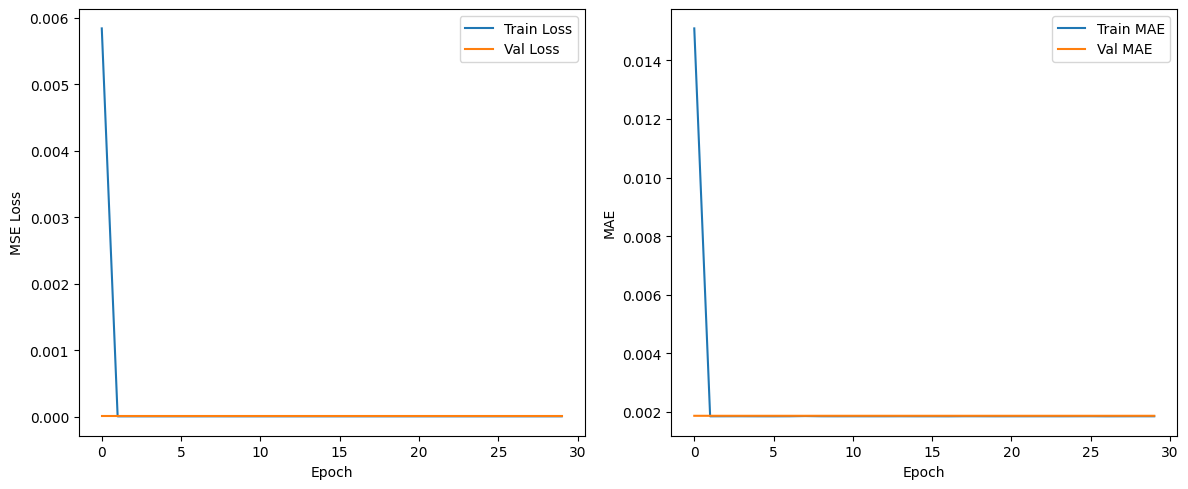

In [25]:
import os
import zipfile
from glob import glob

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

ZIP_FILE_PATH = '/content/kidney+stone.zip'
BASE_EXTRACT_DIR = 'extracted_data'
EXPECTED_DATA_FOLDER = 'kidney stone'
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 30

if not os.path.exists(BASE_EXTRACT_DIR):
    os.makedirs(BASE_EXTRACT_DIR)
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as z:
        z.extractall(BASE_EXTRACT_DIR)

actual_data_root = os.path.join(BASE_EXTRACT_DIR, EXPECTED_DATA_FOLDER)
if not os.path.isdir(actual_data_root):
    actual_data_root = BASE_EXTRACT_DIR

train_dir = os.path.join(actual_data_root, 'train')
valid_dir = os.path.join(actual_data_root, 'valid')
test_dir = os.path.join(actual_data_root, 'test')

def load_data(split_dir):
    imgs = sorted(glob(os.path.join(split_dir, 'final', '*.jpg')))
    lbls = sorted(glob(os.path.join(split_dir, 'labels', '*.txt')))
    if len(imgs) != len(lbls):
        print(f"Warning: {split_dir} has {len(imgs)} images but {len(lbls)} labels")
    return imgs, lbls

train_images, train_labels = load_data(train_dir)
val_images, val_labels = load_data(valid_dir)
test_images, test_labels = load_data(test_dir)

print(f"Train: {len(train_images)}  Val: {len(val_images)}  Test: {len(test_images)}")

def parse_sample(image_path, label_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    lbl = tf.io.read_file(label_path)
    tokens = tf.strings.split(lbl)
    mask = tf.not_equal(tokens, '0')
    coords = tf.boolean_mask(tokens, mask)
    coords = coords[:4]
    coords = tf.strings.to_number(coords, out_type=tf.float32)

    def build_bbox():
        x1, y1, x2, y2 = coords[0], coords[1], coords[2], coords[3]
        H = tf.cast(tf.shape(img)[0], tf.float32)
        W = tf.cast(tf.shape(img)[1], tf.float32)
        cx = (x1 + x2) / (2.0 * W)
        cy = (y1 + y2) / (2.0 * H)
        w = (x2 - x1) / W
        h = (y2 - y1) / H
        return tf.stack([cx, cy, w, h])

    bbox = tf.cond(
        tf.equal(tf.shape(coords)[0], 4),
        true_fn=build_bbox,
        false_fn=lambda: tf.zeros([4], tf.float32)
    )

    return img, bbox

def tf_wrapper(image_path, label_path):
    img, bbox = tf.py_function(
        parse_sample,
        [image_path, label_path],
        [tf.float32, tf.float32]
    )
    img.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    bbox.set_shape([4])
    return img, bbox

def build_dataset(img_paths, lbl_paths, batch_size):
    if not img_paths or not lbl_paths:
        return None
    ds = tf.data.Dataset.from_tensor_slices((img_paths, lbl_paths))
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=min(len(img_paths), 512))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_images, train_labels, BATCH_SIZE)
val_ds = build_dataset(val_images, val_labels, BATCH_SIZE)
test_ds = build_dataset(test_images, test_labels, BATCH_SIZE)

if train_ds is None or val_ds is None:
    raise RuntimeError("No training/validation data found. Check paths.")

def build_model():
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = False
    return tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='sigmoid'),
    ])

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
)

if test_ds is not None:
    test_loss, test_mae = model.evaluate(test_ds)
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


✅ Loaded model from /content/kidney_stone_mobilenetv2_model.h5
Found 123 test images & labels.

Test samples    : 123
Mean IoU        : 0.0000
% IoU ≥ 0.5: 0.00%
Mean MAE(norm)  : 0.0985


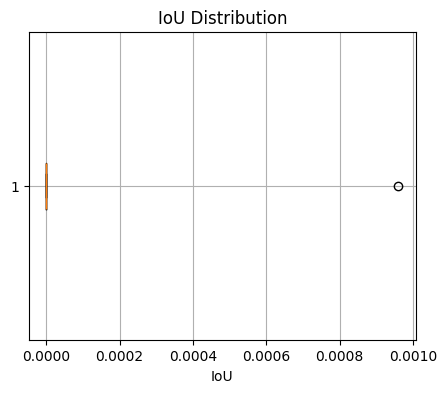

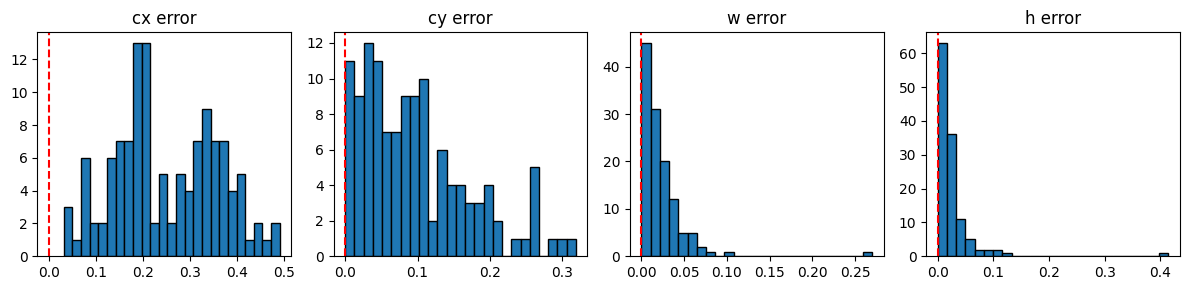

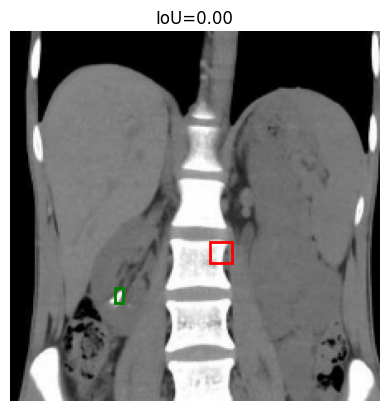

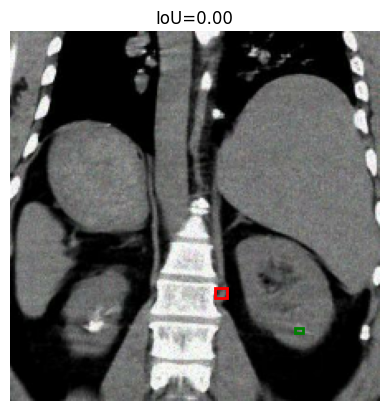

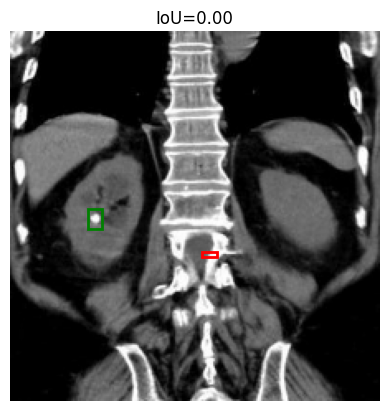

In [59]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.patches as patches

IMAGE_SIZE = 224
THRESH_IOU = 0.5
MODEL_PATH = '/content/kidney_stone_mobilenetv2_model.h5'

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print(f"✅ Loaded model from {MODEL_PATH}")

def load_test_paths(test_dir):
    imgs = sorted(glob(os.path.join(test_dir, 'final', '*.jpg')))
    lbls = sorted(glob(os.path.join(test_dir, 'labels', '*.txt')))
    if len(imgs) != len(lbls):
        raise ValueError(f"Mismatched images ({len(imgs)}) vs labels ({len(lbls)}) in {test_dir}")
    return imgs, lbls

def parse_label_py(label_path):
    toks = open(label_path).read().strip().split()
    if len(toks) >= 5:
        return [float(x) for x in toks[1:5]]
    else:
        return [0.0, 0.0, 0.0, 0.0]

def iou_xyxy(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    union = areaA + areaB - interArea
    return interArea/union if union > 0 else 0.0

def cxcywh_to_xyxy(box_norm):
    cx, cy, w, h = box_norm
    x1 = int((cx - w/2)*IMAGE_SIZE)
    y1 = int((cy - h/2)*IMAGE_SIZE)
    x2 = int((cx + w/2)*IMAGE_SIZE)
    y2 = int((cy + h/2)*IMAGE_SIZE)
    return [x1, y1, x2, y2]

test_dir = 'extracted_data/kidney stone/test'
test_images, test_labels = load_test_paths(test_dir)
print(f"Found {len(test_images)} test images & labels.")

ious, maes = [], []
errors, pred_boxes, gt_boxes = [], [], []

for img_path, lbl_path in zip(test_images, test_labels):
    raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(raw, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = tf.cast(img, tf.float32) / 255.0

    pred_norm = model.predict(tf.expand_dims(img_norm, 0), verbose=0)[0]
    gt_norm = np.array(parse_label_py(lbl_path), dtype=np.float32)

    pred_xy = cxcywh_to_xyxy(pred_norm)
    gt_xy = cxcywh_to_xyxy(gt_norm)

    i = iou_xyxy(pred_xy, gt_xy)
    m = np.mean(np.abs(pred_norm - gt_norm))
    e = np.abs(pred_norm - gt_norm)

    ious.append(i)
    maes.append(m)
    errors.append(e)
    pred_boxes.append(pred_xy)
    gt_boxes.append(gt_xy)

ious = np.array(ious)
maes = np.array(maes)
errors = np.vstack(errors)

print(f"\nTest samples    : {len(ious)}")
print(f"Mean IoU        : {np.mean(ious):.4f}")
print(f"% IoU ≥ {THRESH_IOU}: {(ious >= THRESH_IOU).mean()*100:.2f}%")
print(f"Mean MAE(norm)  : {np.mean(maes):.4f}")

plt.figure(figsize=(5,4))
plt.boxplot(ious, vert=False)
plt.title("IoU Distribution")
plt.xlabel("IoU")
plt.grid(True)
plt.show()

labels = ['cx','cy','w','h']
plt.figure(figsize=(12,3))
for i, lab in enumerate(labels):
    plt.subplot(1,4,i+1)
    plt.hist(errors[:,i], bins=25, edgecolor='black')
    plt.title(f"{lab} error")
    plt.axvline(0, linestyle='--')
plt.tight_layout()
plt.show()

for idx in range(min(3, len(test_images))):
    img_raw = tf.image.decode_jpeg(tf.io.read_file(test_images[idx]), channels=3)
    img_res = tf.image.resize(img_raw, (IMAGE_SIZE, IMAGE_SIZE)).numpy().astype(np.uint8)

    fig, ax = plt.subplots(1)
    ax.imshow(img_res)

    x1, y1, x2, y2 = gt_boxes[idx]
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='green', facecolor='none'))
    x1p, y1p, x2p, y2p = pred_boxes[idx]
    ax.add_patch(patches.Rectangle((x1p,y1p), x2p-x1p, y2p-y1p, linewidth=2, edgecolor='red', facecolor='none'))

    ax.set_title(f"IoU={ious[idx]:.2f}")
    ax.axis('off')
    plt.show()


In [ ]:
def read_label_file_content(label_file_path):
    with open(label_file_path, 'r') as file:
        content = file.read()  # Read the entire content of the file
    return content

# Example usage
label_file_path = '1-3-46-670589-33-1-63705534438072088700001-5205898188246698645_png_jpg.rf.75a856d4d26f9f0323b495186912084d.txt'
content = read_label_file_content(label_file_path)

print("File content:")
print(content)


File content:
0 0.7391304347826086 0.7703125 0.03836317135549872 0.03125
0 0.7915601023017903 0.7953125 0.09718670076726342 0.05
0 0.8260869565217391 0.85 0.04092071611253197 0.040625
0 0.7787723785166241 0.8546875 0.03324808184143223 0.01875
0 0.17135549872122763 0.809375 0.028132992327365727 0.025
0 0.21483375959079284 0.8 0.08439897698209718 0.059375
0 0.2851662404092072 0.721875 0.017902813299232736 0.015625
0 0.30562659846547313 0.7984375 0.10997442455242967 0.0625
0 0.29411764705882354 0.75 0.06905370843989769 0.040625
0 0.7698209718670077 0.871875 0.056265984654731455 0.0375


In [ ]:
def read_and_process_label_file(label_file_path):
    with open(label_file_path, 'r') as file:
        content = file.read()  # Read the entire content of the file

    # Split the content into lines
    lines = content.strip().split('\n')
    coordinates = []

    # Process each line
    for line in lines:
        # Split the line into components
        parts = line.strip().split()

        # Skip the 0th element and process coordinates directly from index 1
        coordinates.append(tuple(map(float, parts[1:])))  # Convert to float instead of int

    return coordinates

# Example usage
label_file_path = '1-3-46-670589-33-1-63705534438072088700001-5205898188246698645_png_jpg.rf.75a856d4d26f9f0323b495186912084d.txt'
coordinates = read_and_process_label_file(label_file_path)

print("Extracted coordinates:")
print(coordinates)


Extracted coordinates:
[(0.7391304347826086, 0.7703125, 0.03836317135549872, 0.03125), (0.7915601023017903, 0.7953125, 0.09718670076726342, 0.05), (0.8260869565217391, 0.85, 0.04092071611253197, 0.040625), (0.7787723785166241, 0.8546875, 0.03324808184143223, 0.01875), (0.17135549872122763, 0.809375, 0.028132992327365727, 0.025), (0.21483375959079284, 0.8, 0.08439897698209718, 0.059375), (0.2851662404092072, 0.721875, 0.017902813299232736, 0.015625), (0.30562659846547313, 0.7984375, 0.10997442455242967, 0.0625), (0.29411764705882354, 0.75, 0.06905370843989769, 0.040625), (0.7698209718670077, 0.871875, 0.056265984654731455, 0.0375)]
